# Pre Processing



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functions import *

# Importing Dataset
df_train = pd.read_csv("DATA\\ravdess_features_dm2\RavdessAudioOnlyFeatures_TRAIN.csv")
df_test = pd.read_csv("DATA\\ravdess_features_dm2\RavdessAudioOnlyFeatures_TEST.csv")

# do a min max standardization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# cet all columns not in CAT
numeric_cols = df_train.columns[~df_train.columns.isin(CAT)]
categorical_cols = CAT

df_train[numeric_cols] = scaler.fit_transform(df_train[numeric_cols])
df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])

# print shape of train and test
print(df_train.shape)
print(df_test.shape)

# droppinf file name cz it doesnt matter
df_train.drop(columns='filename',axis=1, inplace=True)
# drop modality cz its all audio
df_train.drop(columns='modality',axis=1, inplace=True)
# drop actor cz its not important
df_train.drop(columns='actor',axis=1, inplace=True)
# do it also for test
df_test.drop(columns='filename',axis=1, inplace=True)
df_test.drop(columns='modality',axis=1, inplace=True)
df_test.drop(columns='actor',axis=1, inplace=True)

categorical_cols.remove("filename")
categorical_cols.remove("modality")
categorical_cols.remove("actor")

(1828, 434)
(624, 434)


DROP COLUMNS WITH UNIQUE VALUE

In [2]:
unique = find_unique(df_train)
# drop unique columns 
df_train.drop(columns=unique, axis=1, inplace=True)
df_test.drop(columns=unique, axis=1, inplace=True)

# print shape of train and test
print(df_train.shape)
print(df_test.shape)

print(len(unique))

(1828, 380)
(624, 380)
51


CREATE ONE HOT ENCODED VARIABLES

In [3]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# create an instance of the OneHotEncoder class
encoder = OneHotEncoder(categories='auto', sparse=False)

# fit the encoder to the data
encoder.fit(df_train[["emotion"]])

# transform the data using the encoder
encoded_data = encoder.transform(df_train[["emotion"]])

# create a new DataFrame with the one-hot encoded data
encoded_df = pd.DataFrame(encoded_data, columns=[f'{"emotion"}_{i}' for i in range(8)])

# concatenate the original DataFrame with the encoded DataFrame
df_train = pd.concat([df_train, encoded_df], axis=1)
df_train = df_train.drop(columns=["emotion"])

##Test Set
# fit the encoder to the data
encoder.fit(df_test[["emotion"]])

# transform the data using the encoder
encoded_data = encoder.transform(df_test[["emotion"]])

# create a new DataFrame with the one-hot encoded data
encoded_df = pd.DataFrame(encoded_data, columns=[f'{"emotion"}_{i}' for i in range(8)])

# concatenate the original DataFrame with the encoded DataFrame
df_test = pd.concat([df_test, encoded_df], axis=1)
df_test = df_test.drop(columns=["emotion"])

CREATE BINARIZED VARIABLES

In [4]:
# Converting Categorical Attributes to Numeric Values

statement_map = {"Dogs are sitting by the door": 0, "Kids are talking by the door": 1}

emotional_intensity_map = {"normal": 0, "strong": 1}

# emotion_map = {'neutral':0, 'calm':1, 'happy':2, 'sad':3, 'angry':4, 'fearful':5, 'disgust':6, 'surprised':7}

repetition_map = {"1st": 0, "2nd": 1}

vocal_channel_map = {"speech": 0, "song": 1}

sex_map = {"M": 0, "F": 1}
# "emotion": emotion_map
df_train.replace({"sex": sex_map, "emotional_intensity": emotional_intensity_map, 
            "vocal_channel": vocal_channel_map, "repetition": repetition_map, 
           "statement": statement_map}, inplace=True)

df_test.replace({"sex": sex_map, "emotional_intensity": emotional_intensity_map, 
            "vocal_channel": vocal_channel_map, "repetition": repetition_map, 
           "statement": statement_map}, inplace=True)

In [5]:
# remove emotion column from categorical cols and add columns from encoded df
categorical_cols.remove("emotion")
categorical_cols.extend(encoded_df.columns)

numeric_cols = df_train.columns[~df_train.columns.isin(categorical_cols)]


In [6]:
target_name = 'emotional_intensity'

attributes = [col for col in df_train.columns if col != target_name]
# eliminate the target variable from the list of categorical attributes
categorical_att = [col for col in categorical_cols if col != target_name]

In [7]:
# export train and test
df_train.to_csv("RavdessAudioOnlyFeatures_TRAIN_CLEAN.csv", index=False)
df_test.to_csv("RavdessAudioOnlyFeatures_TEST_CLEAN.csv", index=False)

DO TRAIN AND TEST SPLIT

In [7]:
X = df_train[attributes].values
y = df_train[target_name]

In [8]:
X_train = df_train[attributes]
y_train = df_train[target_name]
X_test = df_test[attributes]
y_test = df_test[target_name]
X_train_numeric = df_train[numeric_cols]
X_test_numeric = df_test[numeric_cols]
X_train_cat = df_train[categorical_att]
X_test_cat = df_test[categorical_att]

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val, X_train_numeric, X_val_numeric, X_train_cat, X_val_cat  = train_test_split(X_train, y_train, X_train_numeric, X_train_cat, test_size=0.25, random_state=42)

# Initial Classification test with raw data

## 2)KNN

In [10]:
knn_class(X_train, y_train, X_val, y_val)

{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
0.7315593895155938
Accuracy 0.7461706783369803
F1-score [0.78438662 0.69148936]
              precision    recall  f1-score   support

           0      0.720     0.861     0.784       245
           1      0.793     0.613     0.691       212

    accuracy                          0.746       457
   macro avg      0.756     0.737     0.738       457
weighted avg      0.754     0.746     0.741       457



0.7461706783369803

## Removing Highly Correlated Attributes

In [11]:
max_cor = [0.7, 0.8, 0.9, 0.95, 0.99]
acc = []
for i in max_cor:
    print(f"max_cor = {i}")
    corr_matrix = X_train_numeric.corr()
    corr_list = find_corr_good(corr_matrix, i)
    high_corr = find_out(corr_list, X_train_numeric.columns)

    print('Number of highly correlated features:', len(high_corr), 'for threshold:', i, 'remaining features:', len(X_train.columns) - len(high_corr))
    X_train_cor = copy_df_and_drop(X_train, high_corr)
    X_val_cor = copy_df_and_drop(X_val, high_corr)

    acc.append(knn_class(X_train_cor, y_train, X_val_cor, y_val))

# print best acc and corresponding treshold 
print('Max accuracy', max(acc), 'At treshold', max_cor[acc.index(max(acc))])

max_cor = 0.7
Number of highly correlated features: 246 for threshold: 0.7 remaining features: 140
{'n_neighbors': 18, 'p': 1, 'weights': 'distance'}
0.7031081619110815
Accuracy 0.687089715536105
F1-score [0.75638842 0.56269113]
              precision    recall  f1-score   support

           0      0.649     0.906     0.756       245
           1      0.800     0.434     0.563       212

    accuracy                          0.687       457
   macro avg      0.725     0.670     0.660       457
weighted avg      0.719     0.687     0.667       457

max_cor = 0.8
Number of highly correlated features: 202 for threshold: 0.8 remaining features: 184
{'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
0.713335102853351
Accuracy 0.6980306345733042
F1-score [0.76450512 0.57926829]
              precision    recall  f1-score   support

           0      0.657     0.914     0.765       245
           1      0.819     0.448     0.579       212

    accuracy                          0.698       4

## Removing Low Variance Features

In [12]:
var_tresh = [0.1, 0.01, 0.005, 0.002, 0.001]

acc = []
for i in var_tresh:
    var = X_train.var().sort_values()
    var = var[var < i]
    print(f"var_tresh = {i}", 'Number of features eliminated:', len(var), 'remaining features:', len(X_train.columns) - len(var))
    X_train_var = copy_df_and_drop(X_train, var.index)
    X_val_var = copy_df_and_drop(X_val, var.index)
    acc.append(knn_class(X_train_var, y_train, X_val_var, y_val))

# print best acc and corresponding treshold
print('Max accuracy', max(acc), 'At treshold', var_tresh[acc.index(max(acc))])

var_tresh = 0.1 Number of features eliminated: 374 remaining features: 12
{'n_neighbors': 30, 'p': 1, 'weights': 'uniform'}
0.5317292634372927
Accuracy 0.5426695842450766
F1-score [0.6463621  0.35294118]
              precision    recall  f1-score   support

           0      0.552     0.780     0.646       245
           1      0.514     0.269     0.353       212

    accuracy                          0.543       457
   macro avg      0.533     0.524     0.500       457
weighted avg      0.534     0.543     0.510       457

var_tresh = 0.01 Number of features eliminated: 106 remaining features: 280
{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
0.7279044459190445
Accuracy 0.7155361050328227
F1-score [0.75095785 0.66836735]
              precision    recall  f1-score   support

           0      0.708     0.800     0.751       245
           1      0.728     0.618     0.668       212

    accuracy                          0.716       457
   macro avg      0.718     0.709     0.710  

# Dimensionality reduction

## 3)Recursive Feature Elimination

In [17]:
# create a range of numbers of features to select
num_features = [25, 30, 40, 50, 60, 75, 100, 125, 150]

selected_features = []

rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
acc = []
for i in num_features:
    rfe_selected = RFE(estimator = rfc, step = 5, n_features_to_select = i)
    rfe_selected.fit(X_train, y_train)
    rfe_selected_features = X_train.columns[rfe_selected.support_]


    # evaluate the performance of the classifier
    print(f'Number of features: {i}')
    acc.append(knn_class(X_train[rfe_selected_features], y_train, X_val[rfe_selected_features], y_val))

    selected_features.append(rfe_selected_features)

# print best acc and corresponding number of features
print('Max accuracy', max(acc), 'At number of features', num_features[acc.index(max(acc))])

Number of features: 25
{'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
0.7541818181818181
Accuracy 0.7221006564551422
F1-score [0.75435203 0.68010076]
              precision    recall  f1-score   support

           0      0.717     0.796     0.754       245
           1      0.730     0.637     0.680       212

    accuracy                          0.722       457
   macro avg      0.723     0.716     0.717       457
weighted avg      0.723     0.722     0.720       457

Number of features: 30
{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
0.7541844724618447
Accuracy 0.7308533916849015
F1-score [0.75449102 0.70217918]
              precision    recall  f1-score   support

           0      0.738     0.771     0.754       245
           1      0.721     0.684     0.702       212

    accuracy                          0.731       457
   macro avg      0.730     0.728     0.728       457
weighted avg      0.730     0.731     0.730       457

Number of features: 40
{'n_neighbors': 4

In [ ]:
# write selected features from max acc
with open('selected_features_def.txt', 'w') as f:
    for item in selected_features[acc.index(max(acc))]:
        f.write("%s\n" % item)

In [10]:
# get features from file
with open('selected_features.txt', 'r') as f:
    sel = f.read().splitlines()

X_train_sf = X_train[sel]
X_val_sf = X_val[sel]

In [18]:
X_train_sf = X_train[selected_features[acc.index(max(acc))]]
X_val_sf = X_val[selected_features[acc.index(max(acc))]]

knn_class(X_train_sf, y_train, X_val_sf, y_val)

{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
0.7928334439283344
Accuracy 0.7811816192560175
F1-score [0.80769231 0.74619289]
              precision    recall  f1-score   support

           0      0.764     0.857     0.808       245
           1      0.808     0.693     0.746       212

    accuracy                          0.781       457
   macro avg      0.786     0.775     0.777       457
weighted avg      0.784     0.781     0.779       457



0.7811816192560175

## 4)PCA

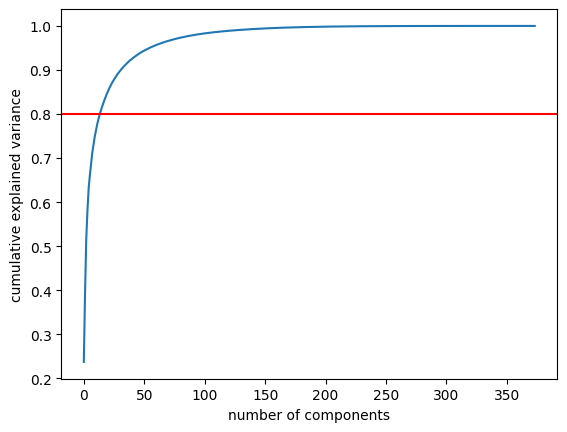

14


In [19]:
# do a pca on X_train_numeric and show me the skree plot
pca = PCA()
pca.fit(X_train_numeric)


# plot the cumulative variance explained with respect to the number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

# put a line at 0.8 and see how many components we need to explain 80% of the variance
plt.axhline(y=0.8, color='r', linestyle='-')
plt.show()

# tell me how many components to reach 80% variance
print(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.8)[0][0])
n_com = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.8)[0][0]

In [20]:
exp_var = [0.8, 0.85, 0.9, 0.95, 0.99]
acc = []
for i in exp_var:
    pca = PCA()
    pca.fit(X_train_numeric)
    n_com = np.where(np.cumsum(pca.explained_variance_ratio_) > i)[0][0]
    print(f'Explained variance: {i}')
    print(f'Number of components: {n_com}')
    pca2 = PCA(n_components = n_com)
    pca2.fit(X_train_numeric)

# transform X_train_numeric and X_val_numeric
    X_train_pca = pca2.transform(X_train_numeric)
    X_val_pca = pca2.transform(X_val_numeric)
    # add X_train_cat and X_val_cat to X_train_pca and X_val_pca
    X_train_pca = np.concatenate((X_train_pca, X_train_cat), axis=1)
    X_val_pca = np.concatenate((X_val_pca, X_val_cat), axis=1)

    acc.append(knn_class(X_train_pca, y_train, X_val_pca, y_val))

# print best acc and corresponding explained variance
print('Max accuracy', max(acc), 'At explained variance', exp_var[acc.index(max(acc))], 'with', np.where(np.cumsum(pca.explained_variance_ratio_) > exp_var[acc.index(max(acc))])[0][0], 'components')

Explained variance: 0.8
Number of components: 14
{'n_neighbors': 28, 'p': 2, 'weights': 'distance'}
0.7235593895155938
Accuracy 0.7177242888402626
F1-score [0.77005348 0.63456091]
              precision    recall  f1-score   support

           0      0.684     0.882     0.770       245
           1      0.794     0.528     0.635       212

    accuracy                          0.718       457
   macro avg      0.739     0.705     0.702       457
weighted avg      0.735     0.718     0.707       457

Explained variance: 0.85
Number of components: 20
{'n_neighbors': 21, 'p': 1, 'weights': 'distance'}
0.7264525547445255
Accuracy 0.7089715536105032
F1-score [0.76207513 0.62535211]
              precision    recall  f1-score   support

           0      0.678     0.869     0.762       245
           1      0.776     0.524     0.625       212

    accuracy                          0.709       457
   macro avg      0.727     0.696     0.694       457
weighted avg      0.724     0.709     0.

PCA ON 50 MOST IMPORTANT FEATURES

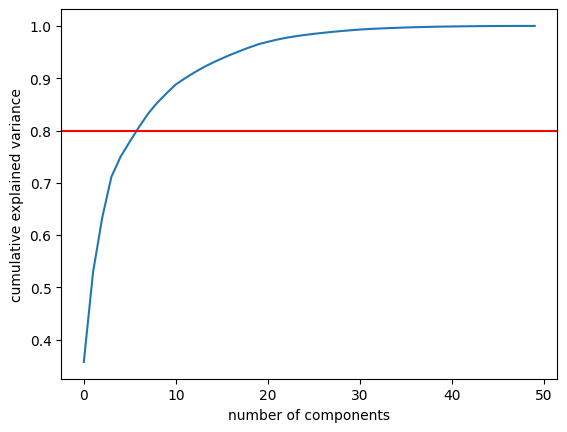

6


In [21]:
# do a pca and plot cumulative explained variance for X_train_sf
pca = PCA()
pca.fit(X_train_sf)

# plot the cumulative variance explained with respect to the number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

# put a line at 0.8 and see how many components we need to explain 80% of the variance
plt.axhline(y=0.8, color='r', linestyle='-')
plt.show()

# tell me how many components to reach 80% variance
print(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.8)[0][0])

In [22]:
exp_var = [0.8, 0.85, 0.9, 0.95, 0.99]
acc = []
for i in exp_var:
    pca = PCA()
    pca.fit(X_train_sf)
    n_com = np.where(np.cumsum(pca.explained_variance_ratio_) > i)[0][0]
    print(f'Explained variance: {i}')
    print(f'Number of components: {n_com}')
    pca2 = PCA(n_components = n_com)
    pca2.fit(X_train_sf)

# transform X_train_numeric and X_val_numeric
    X_train_pca = pca2.transform(X_train_sf)
    X_val_pca = pca2.transform(X_val_sf)
    # add X_train_cat and X_val_cat to X_train_pca and X_val_pca

    acc.append(knn_class(X_train_pca, y_train, X_val_pca, y_val))

# print best acc and corresponding explained variance
print('Max accuracy', max(acc), 'At explained variance', exp_var[acc.index(max(acc))], 'with', np.where(np.cumsum(pca.explained_variance_ratio_) > exp_var[acc.index(max(acc))])[0][0], 'components')

Explained variance: 0.8
Number of components: 6
{'n_neighbors': 22, 'p': 2, 'weights': 'distance'}
0.7760690112806901
Accuracy 0.7308533916849015
F1-score [0.77009346 0.67546174]
              precision    recall  f1-score   support

           0      0.710     0.841     0.770       245
           1      0.766     0.604     0.675       212

    accuracy                          0.731       457
   macro avg      0.738     0.722     0.723       457
weighted avg      0.736     0.731     0.726       457

Explained variance: 0.85
Number of components: 8
{'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
0.7819057730590577
Accuracy 0.7527352297592997
F1-score [0.78638941 0.70649351]
              precision    recall  f1-score   support

           0      0.732     0.849     0.786       245
           1      0.786     0.642     0.706       212

    accuracy                          0.753       457
   macro avg      0.759     0.745     0.746       457
weighted avg      0.757     0.753     0.74

In [27]:
features = sel
features.append(target_name)

df_test_fin = df_test[features]
df_train_fin = df_train[features]

df_test_fin.to_csv('test_final.csv', index=False)
df_train_fin.to_csv('train_final.csv', index=False)